In [2]:
import pandas as pd 
from sqlalchemy import create_engine
import os
from  parser import Movies_parser
import matplotlib.pyplot as plt
import seaborn as sns

## Calling the parser function to get Dataframe

In [3]:
df =Movies_parser() 
df.head()

Parsing the movies data...


,Title,Year,Duration,Content_Rating,User_rating
0,The Shawshank Redemption,1994,2h 22m,R,9.3
1,The Godfather,1972,2h 55m,R,9.2
2,The Dark Knight,2008,2h 32m,PG-13,9.1
3,Schindler's List,1993,3h 15m,R,9.0
4,12 Angry Men,1957,1h 36m,Approved,9.0


#Cleaning the data

In [4]:
df.isnull().sum()

Title             0
Year              0
Duration          0
Content_Rating    0
User_rating       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           250 non-null    object
 1   Year            250 non-null    object
 2   Duration        250 non-null    object
 3   Content_Rating  250 non-null    object
 4   User_rating     250 non-null    object
dtypes: object(5)
memory usage: 9.9+ KB


#We need to change the type of Year and User_rating since they are Objects

In [6]:
df['Year']=df['Year'].astype('int64')
df['User_rating']=df['User_rating'].astype('float64')
#I like to change name of  User_rating to User_Rating
df.rename(columns={'User_rating':'User_Rating'}, inplace=True)
#let's see the changes
df.dtypes

Title              object
Year                int64
Duration           object
Content_Rating     object
User_Rating       float64
dtype: object

#I don't like Duration as Object which might be a problem later. So we need to make that duation as Integer
#Duration includes h & m as hours and minutes so we need to change them as integer(Total Minutes)
#Let's make a function for that

In [7]:
def duration_converter(text):
    if text == 'N/A' or pd.isna(text):
        return None
    hours = 0
    minutes = 0
    if 'h' in text:
        parts=text.split('h')
        hours = int((parts[0]).strip())*60
        if 'm' in text:
            minutes = int(parts[1].replace('m','').strip())
     #incase there is only minutes       
    elif 'm' in text:
        minutes = int(text.replace('m','').strip())
    return hours + minutes

In [8]:
df['Numeric_Duration'] = df['Duration'].apply(duration_converter)
df.head()

,Title,Year,Duration,Content_Rating,User_Rating,Numeric_Duration
0,The Shawshank Redemption,1994,2h 22m,R,9.3,142
1,The Godfather,1972,2h 55m,R,9.2,175
2,The Dark Knight,2008,2h 32m,PG-13,9.1,152
3,Schindler's List,1993,3h 15m,R,9.0,195
4,12 Angry Men,1957,1h 36m,Approved,9.0,96


In [9]:
#Let's drop the original Duration column and rename the new one
df.drop(columns=['Duration'], inplace=True)
df.rename(columns={'Numeric_Duration':'Duration(Minutes)'}, inplace=True)
df.head()

,Title,Year,Content_Rating,User_Rating,Duration(Minutes)
0,The Shawshank Redemption,1994,R,9.3,142
1,The Godfather,1972,R,9.2,175
2,The Dark Knight,2008,PG-13,9.1,152
3,Schindler's List,1993,R,9.0,195
4,12 Angry Men,1957,Approved,9.0,96


In [10]:
#Lets clean cloumns for better sql usgae
df.columns = df.columns.str.strip().str.lower().str.replace(' ','_')

df.head()

,title,year,content_rating,user_rating,duration(minutes)
0,The Shawshank Redemption,1994,R,9.3,142
1,The Godfather,1972,R,9.2,175
2,The Dark Knight,2008,PG-13,9.1,152
3,Schindler's List,1993,R,9.0,195
4,12 Angry Men,1957,Approved,9.0,96


#Let's see the movies trend based on the rating over the years

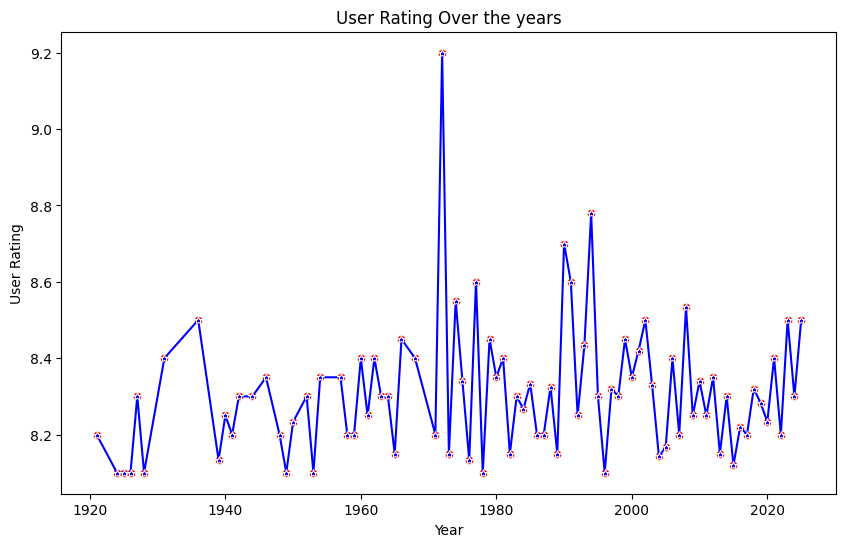

In [11]:
dfyear =df.groupby('year')['user_rating'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=dfyear,x='year',y='user_rating', color='blue', marker='*')
sns.scatterplot(data=dfyear,x='year',y='user_rating', color='red')
plt.title('User Rating Over the years')
plt.xlabel('Year')
plt.ylabel('User Rating')
plt.show()


#Based on the Line chart above, we can say there have not been so many great movies released between 1980 until 1990 on average

#let's see the top 10 movies with their ratings

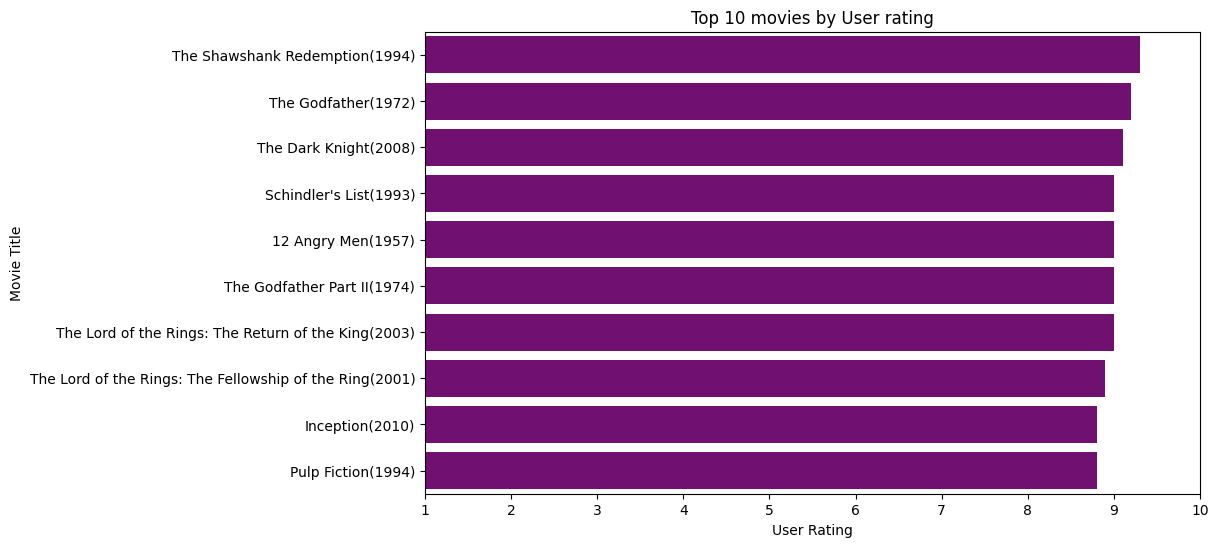

In [12]:
df_top10 =df.sort_values(by='user_rating', ascending=False).head(10)
#let's create a new column for better visualization
df_top10['title_year']=df_top10['title'] + '(' + df_top10['year'].astype(str) + ')'
plt.figure(figsize=(10,6))
sns.barplot(data=df_top10, x='user_rating', y='title_year', color='purple',dodge=True)
plt.title('Top 10 movies by User rating')
plt.xlabel('User Rating')
plt.ylabel('Movie Title')
plt.xlim(1,10)
plt.show()

#Let's see the correlation of Rating, Duration and Year by using Heatmap

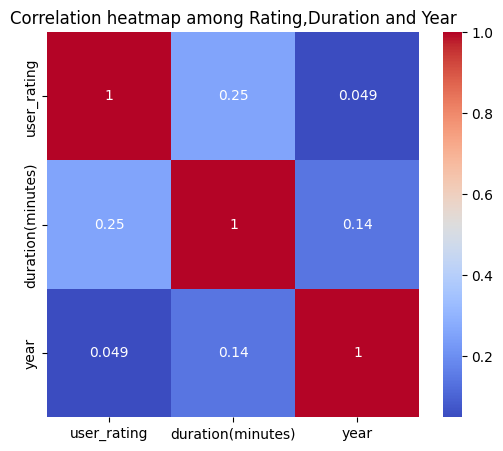

In [13]:
numeric_cols = ['user_rating','duration(minutes)','year']
cor = df[numeric_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap among Rating,Duration and Year')
plt.show()

#we can see that there is a certain amount of correlation between duaration and user_rating

#This time, let's see whether the movie runtime has been changed throung the history like getting longer or shorter

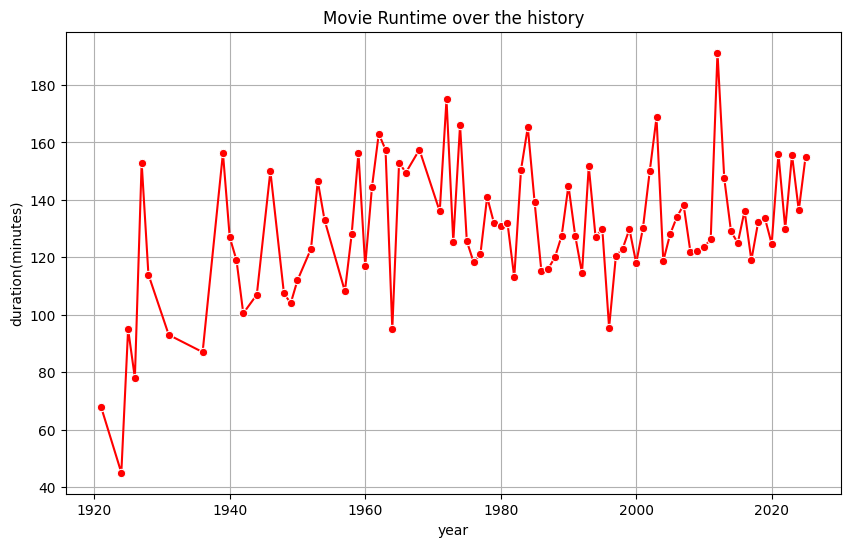

In [14]:
df_yd=df.groupby('year')['duration(minutes)'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=df_yd, x='year',y='duration(minutes)',color='r',marker='o')
sns.scatterplot(data=df_yd,x='year',y='duration(minutes)')
plt.title('Movie Runtime over the history')
#plt.xlim(1990,2024)
plt.grid(True)
plt.show()

#Acoording to the plot above, we can assume that movie runtime has been longer over the period but fallen shorter in recent year.May be because The movie producers are seperating longer movies into two or three movies as sequel like Avenger: Infinity War and Avenger:End Game. 

In [23]:
#to extract the movies released 2000 and later
movies_21=df[df['year']>=2000].copy()
#Choosing the top rating movies 
latest_movies=movies_21.sort_values('user_rating',ascending=False)
#Selecting 20 top rated movies after 2000
top_movies20 = latest_movies.head(20)
#let's combine title and year for better visualization
top_movies20['title_year']=top_movies20['title'] + '('+ top_movies20['year'].astype(str) + ')'
#in dataframe above, I found the movie '12th Fail' has wrong values for contnet rating so i will change it to Unknown
df.loc[df['content_rating']=='2h 27m','content_rating']='Unknown'
top_movies20.loc[df['content_rating']=='2h 27m','content_rating']='Unknown'
top_movies20 

C:\Users\Herry\AppData\Local\Temp\ipykernel_12396\776891932.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_movies20['title_year']=top_movies20['title'] + '('+ top_movies20['year'].astype(str) + ')'


,title,year,content_rating,user_rating,duration(minutes),title_year
2,The Dark Knight,2008,PG-13,9.1,152,The Dark Knight(2008)
6,The Lord of the Rings: The Return of the King,2003,PG-13,9.0,201,The Lord of the Rings: The Return of the King(...
7,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,8.9,178,The Lord of the Rings: The Fellowship of the R...
8,Inception,2010,PG-13,8.8,148,Inception(2010)
13,The Lord of the Rings: The Two Towers,2002,PG-13,8.8,179,The Lord of the Rings: The Two Towers(2002)
14,Interstellar,2014,PG-13,8.7,169,Interstellar(2014)
18,12th Fail,2023,Unknown,8.7,147,12th Fail(2023)
24,City of God,2002,R,8.6,130,City of God(2002)
28,Spirited Away,2001,PG,8.6,124,Spirited Away(2001)
32,Jai Bhim,2021,Approved,8.6,164,Jai Bhim(2021)


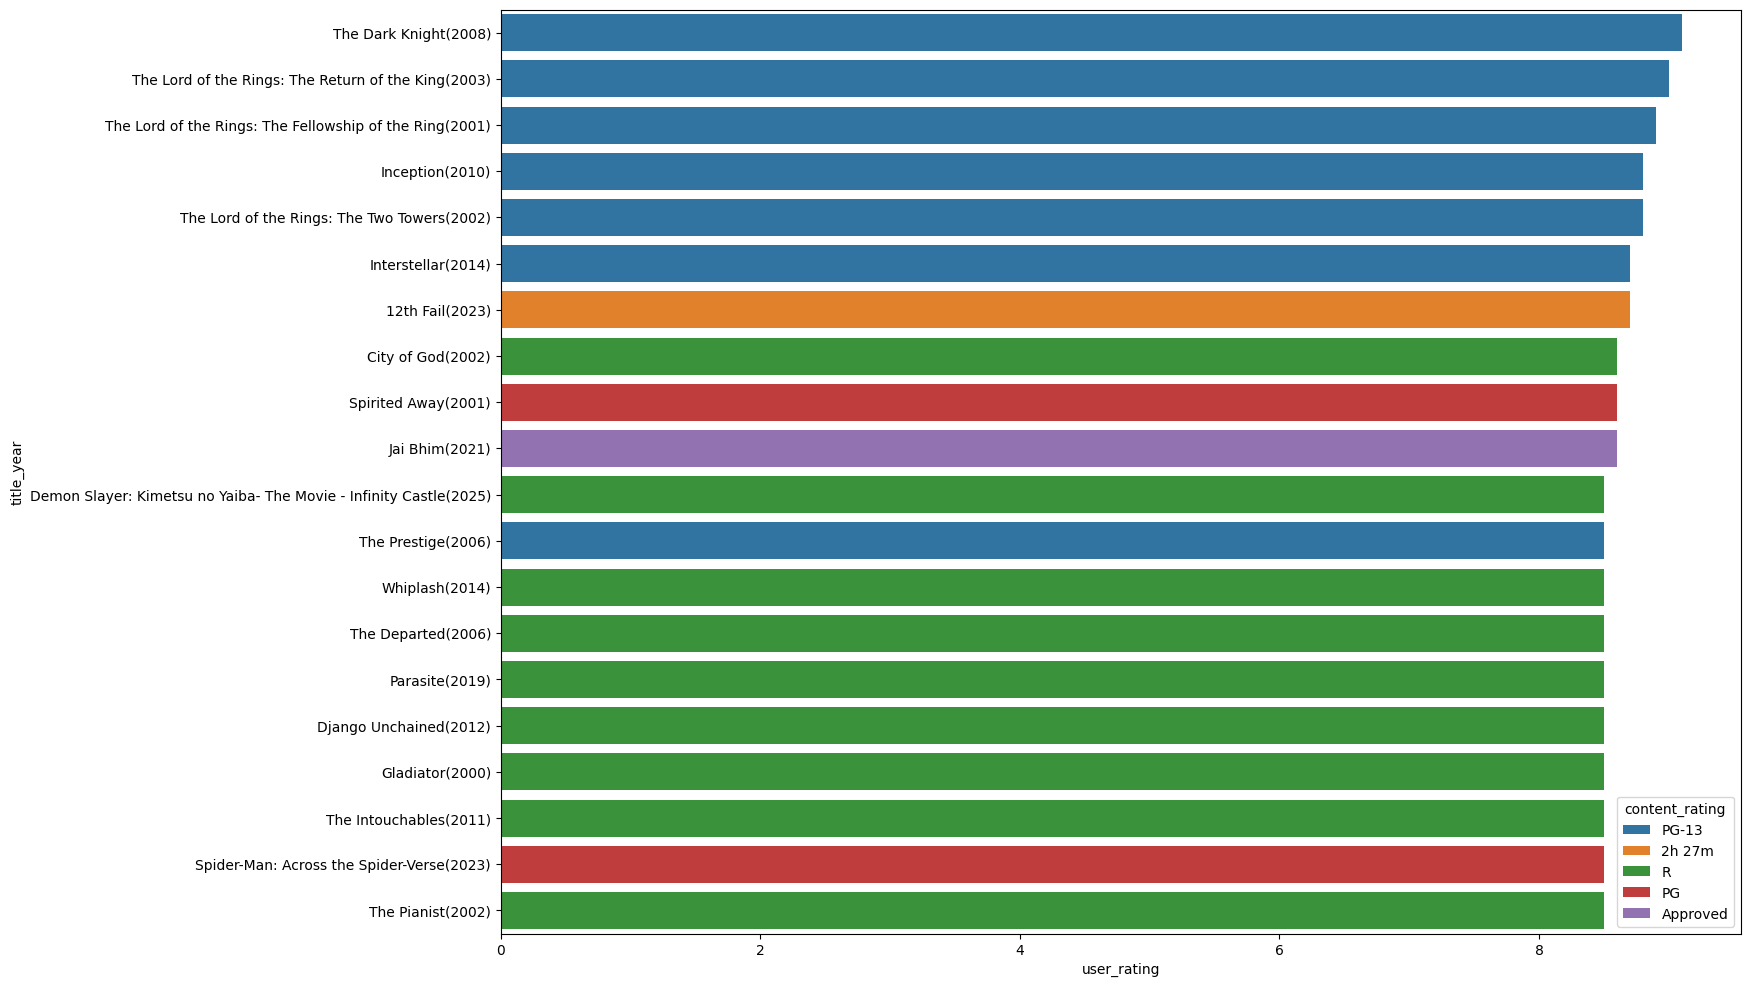

In [16]:

plt.figure(figsize=(16,12))
sns.barplot(data=top_movies20,
            x='user_rating',
            y='title_year',
            hue='content_rating'
            )

plt.show()

#So we can see clearly that the top 6 movies are PG-13

#After all that, now it is time to connect with sql

In [17]:
from sqlalchemy import create_engine
db_name ='Movies_Project.db'
conn_string =f"sqlite:///{db_name}"
engine =create_engine(conn_string)

print(f'Engine successfully created for {db_name}')

Engine successfully created for Movies_Project.db


In [18]:
try:
    df.to_sql('Top_Movies', con=engine, if_exists='replace', index=False)
    print("Datafrme has been successfully written to database")
except Exception as e:
    print(f'Error occured as {e}')

Datafrme has been successfully written to database


In [19]:
%load_ext sql 
%sql engine 
%sql select * from Top_Movies;

Running query in 'sqlite:///Movies_Project.db'

title,year,content_rating,user_rating,duration(minutes)
The Shawshank Redemption,1994,R,9.3,142
The Godfather,1972,R,9.2,175
The Dark Knight,2008,PG-13,9.1,152
Schindler's List,1993,R,9.0,195
12 Angry Men,1957,Approved,9.0,96
The Godfather Part II,1974,R,9.0,202
The Lord of the Rings: The Return of the King,2003,PG-13,9.0,201
The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,8.9,178
Inception,2010,PG-13,8.8,148
Pulp Fiction,1994,R,8.8,154


#Let's see the movies of 21st Century

In [20]:
%sql select * from Top_Movies where year > 2000 order by user_rating desc limit 10;

Running query in 'sqlite:///Movies_Project.db'

title,year,content_rating,user_rating,duration(minutes)
The Dark Knight,2008,PG-13,9.1,152
The Lord of the Rings: The Return of the King,2003,PG-13,9.0,201
The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,8.9,178
Inception,2010,PG-13,8.8,148
The Lord of the Rings: The Two Towers,2002,PG-13,8.8,179
Interstellar,2014,PG-13,8.7,169
12th Fail,2023,Unknown,8.7,147
City of God,2002,R,8.6,130
Spirited Away,2001,PG,8.6,124
Jai Bhim,2021,Approved,8.6,164


In [21]:
%sql select title ,content_rating, user_rating, year from Top_Movies where year<1990 limit 1

Running query in 'sqlite:///Movies_Project.db'

title,content_rating,user_rating,year
The Godfather,R,9.2,1972


In [22]:
%sql select title ,content_rating, user_rating, year from Top_Movies where year<1970 limit 1

Running query in 'sqlite:///Movies_Project.db'

title,content_rating,user_rating,year
12 Angry Men,Approved,9.0,1957
